In [1]:
import os
import numpy as np
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict, Counter
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import cv2

import keras
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

Using TensorFlow backend.
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [77]:
data_path = "data"
labels_file = "masks.json"
img_size = (400, 300, 3)
class_nb = 1

In [78]:
colors = [(0, 0, 255),
           (255, 0, 0),
           (0, 255, 0),
           (255, 255, 0),
           (0, 102, 0),
           (255, 0, 255),
           (0, 255, 255),
           (255, 102, 255),
           (102, 51, 0),
           (255, 153, 51)]

In [79]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, shuffle=False, preprocess=None):
        super().__init__()
        self.data = data
        self.file_names = np.array(list(self.data.keys()))
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def preprocess(X):
        return X
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_size[1], img_size[0], img_size[2]), dtype=np.float32)
        y = np.empty((self.batch_size, img_size[1], img_size[0], self.class_nb), dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, f in enumerate([self.file_names[idx] for idx in indexes]):
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((img_size[0], img_size[1]))
            for j in range(self.class_nb):
                if str(j) in self.data[f]:
                    y[i,:,:,j] = build_masks(self.data[f][str(j)], img_size[1], img_size[0])
                else:
                    y[i,:,:,j] = np.zeros((img_size[1],img_size[0]) ,dtype=np.uint8)
        if self.preprocess!=None: 
            X = self.preprocess(X)
        return X, y

In [80]:
def build_masks(class_data, h, w):
    drawing = np.zeros((h, w), np.uint8)
    for zone in class_data:
        zones = []
        for i, cnt in enumerate(zone):
            cnt0 = int(cnt[0] * w)
            cnt1 = int(cnt[1] * h)
            zones.append([cnt0, cnt1])
        cv2.drawContours(drawing, [np.array(zones)],-1,(1),-1)
    return drawing

c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


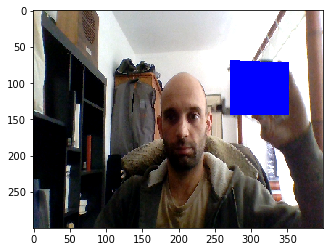

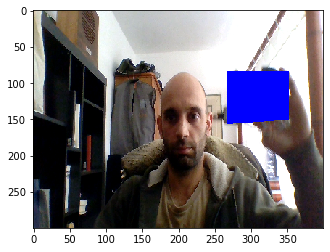

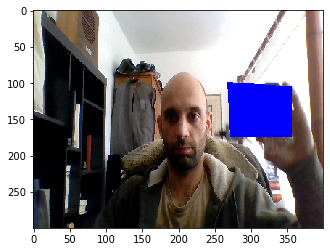

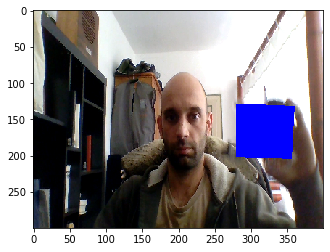

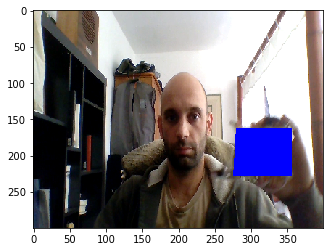

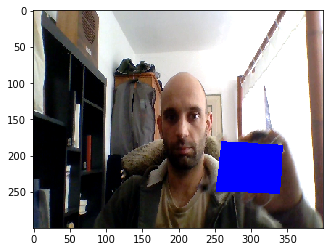

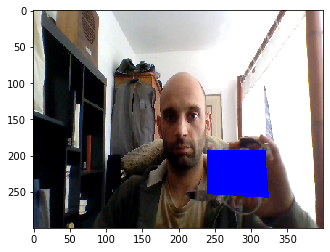

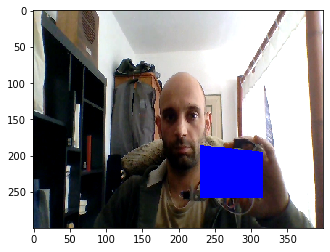

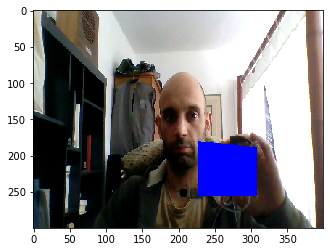

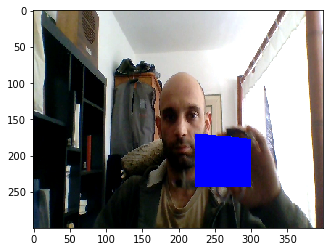

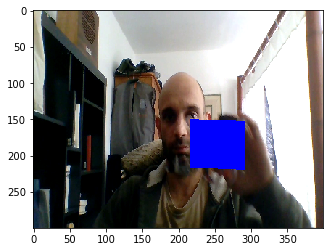

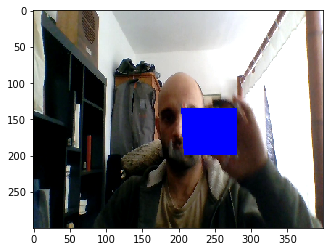

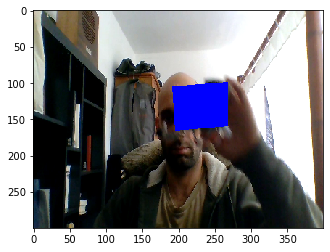

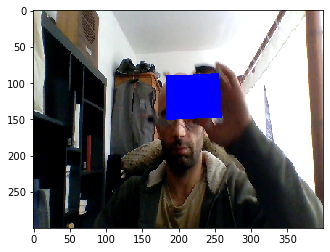

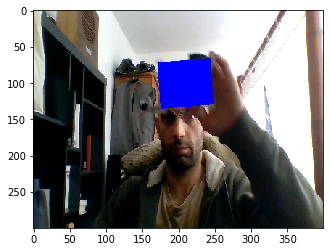

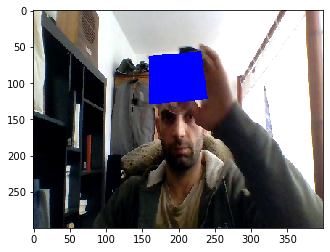

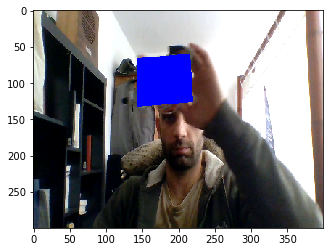

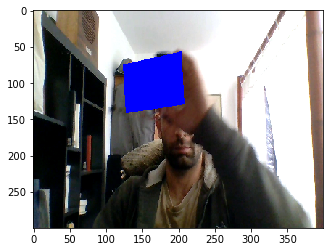

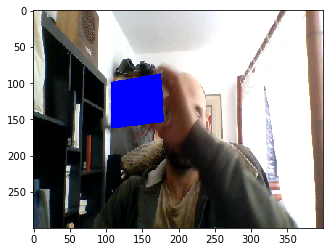

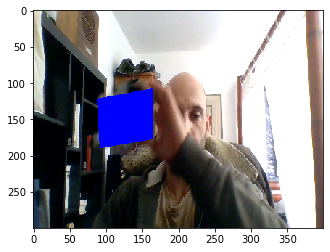

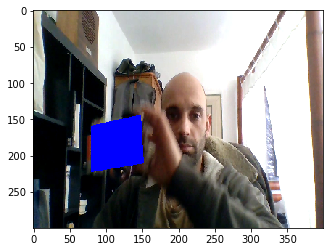

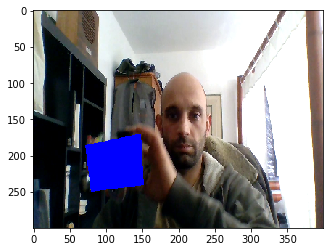

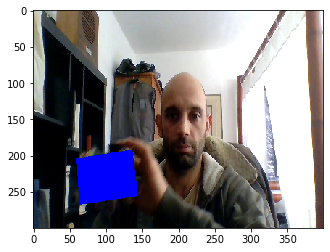

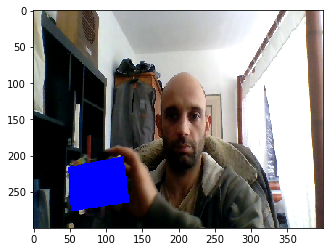

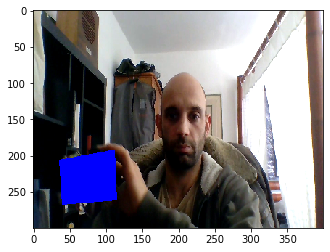

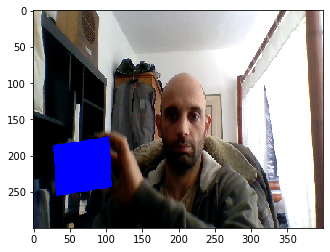

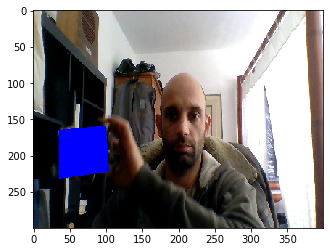

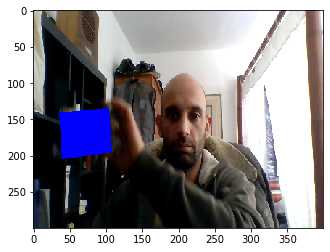

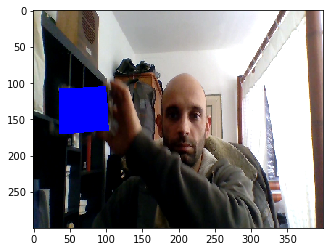

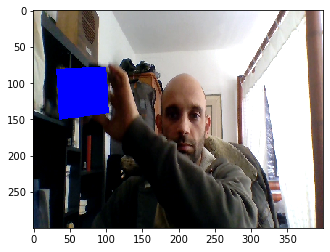

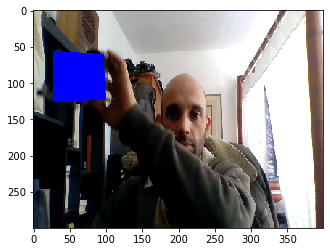

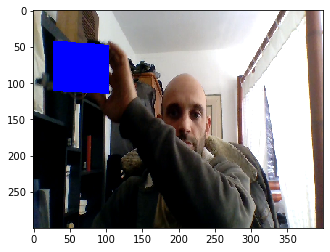

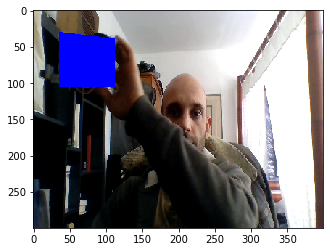

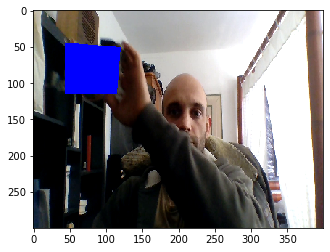

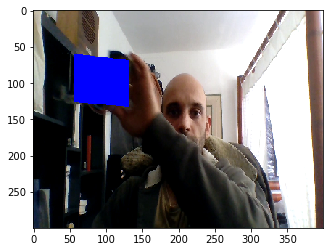

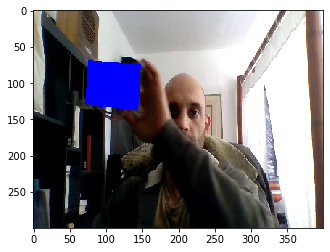

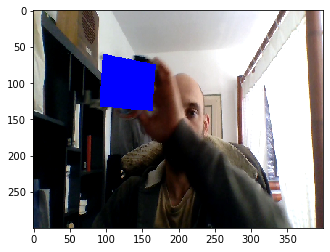

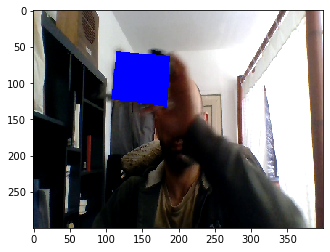

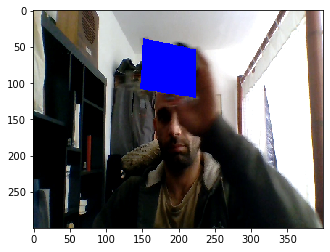

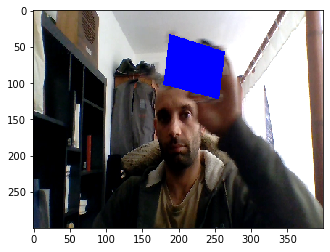

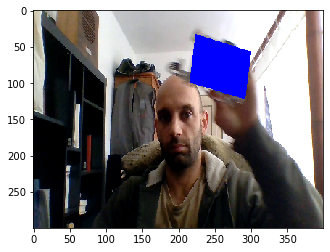

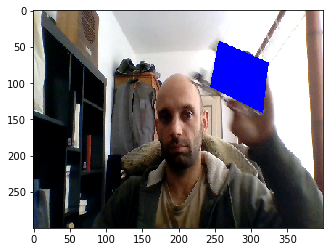

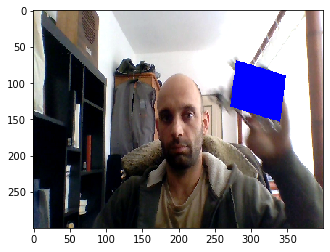

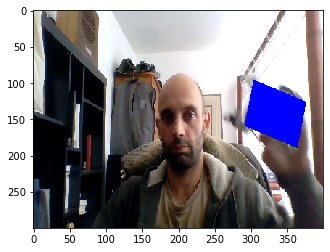

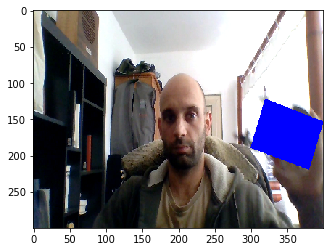

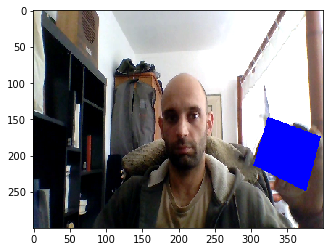

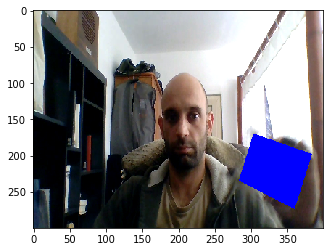

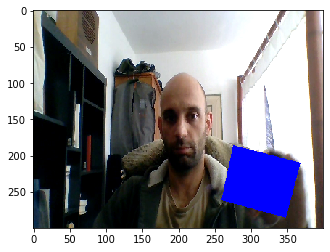

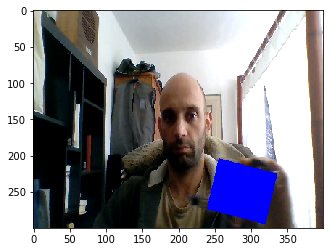

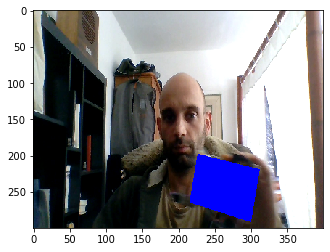

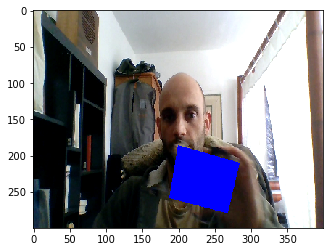

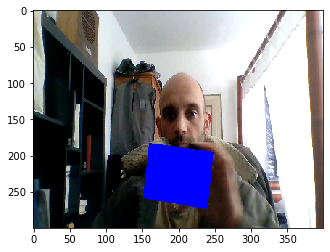

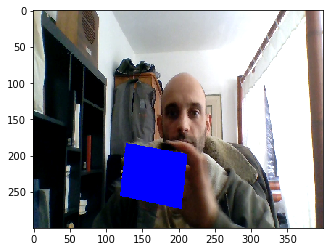

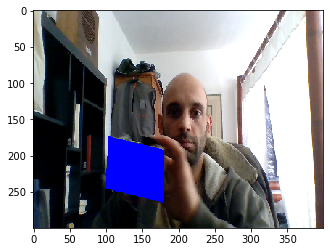

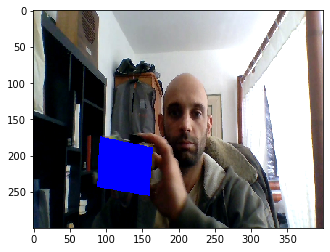

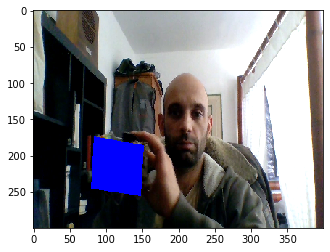

In [81]:
with open(labels_file) as f:
    dict_data = json.load(f)

batch_size = 8
train_batches = DataGenerator(dict_data, data_path, class_nb, batch_size=batch_size)

for batch in train_batches:
    for i in range(batch_size):
        img = batch[0][i,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        for j in range(class_nb):
            msk = batch[1][i,:,:,j]
            img[msk==1] = colors[j]
        plt.figure()
        plt.imshow(img)

In [82]:
# metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model_name = "model.h5"
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='dice_coef', verbose=1, save_best_only=True, mode='max')

In [83]:
K.clear_session()

img_in = Input(shape=(img_size[1], img_size[0], img_size[2]), name='img_in')

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_in)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#drop4 = Dropout(0.5)(conv4)

#pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
#conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#drop5 = Dropout(0.5)(conv5)

#up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#merge6 = concatenate([drop4,up6], axis = 3)
#conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#merge7 = concatenate([conv3,up7], axis = 3)
#conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
out = Conv2D(class_nb, 1, activation = 'sigmoid')(conv9)


model = Model(inputs=img_in, outputs=out)

model.compile(optimizer = "adadelta", loss = 'binary_crossentropy', metrics = [dice_coef])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 300, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 400, 64) 1792        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 300, 400, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 150, 200, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [96]:
idx = int(0.8*len(dict_data))
train_data = {k: dict_data[k] for k in list(dict_data)[:idx]}
val_data = {k: dict_data[k] for k in list(dict_data)[idx:]}

batch_size = 1
train_batches = DataGenerator(train_data, data_path, class_nb, batch_size=batch_size, shuffle=True)
val_batches = DataGenerator(val_data, data_path, class_nb, batch_size=batch_size)

history = model.fit_generator(train_batches, validation_data = val_batches, epochs = 20, verbose=1, callbacks=[best_checkpoint])

Epoch 1/20
48/48 [==============================] - 3s 71ms/step - loss: 0.0214 - dice_coef: 0.8959 - val_loss: 0.1047 - val_dice_coef: 0.6195

Epoch 00001: dice_coef did not improve from 0.93029
Epoch 2/20
48/48 [==============================] - 3s 70ms/step - loss: 0.0106 - dice_coef: 0.9243 - val_loss: 0.1938 - val_dice_coef: 0.6370

Epoch 00002: dice_coef did not improve from 0.93029
Epoch 3/20
48/48 [==============================] - 3s 70ms/step - loss: 0.0089 - dice_coef: 0.9386 - val_loss: 0.1111 - val_dice_coef: 0.7657

Epoch 00003: dice_coef improved from 0.93029 to 0.93855, saving model to model.h5
Epoch 4/20
48/48 [==============================] - 3s 70ms/step - loss: 0.0079 - dice_coef: 0.9441 - val_loss: 0.2508 - val_dice_coef: 0.6265

Epoch 00004: dice_coef improved from 0.93855 to 0.94408, saving model to model.h5
Epoch 5/20
48/48 [==============================] - 3s 70ms/step - loss: 0.0189 - dice_coef: 0.8865 - val_loss: 0.1962 - val_dice_coef: 0.7098

Epoch 00005:

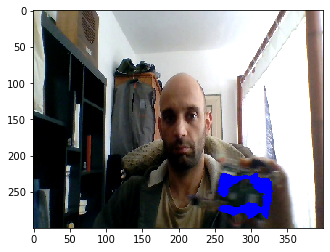

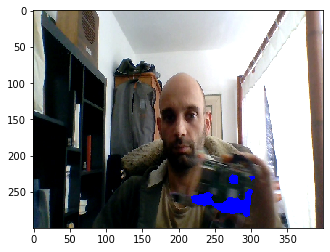

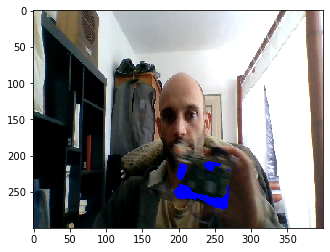

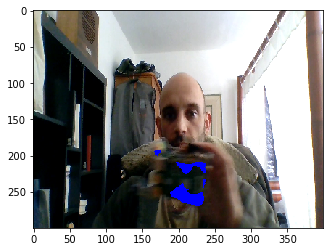

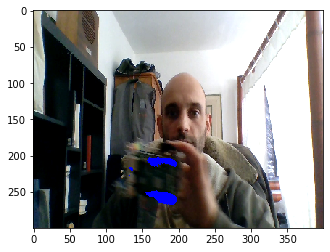

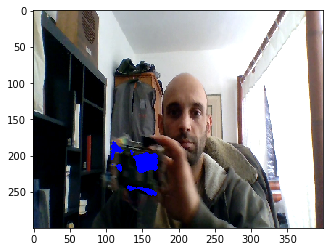

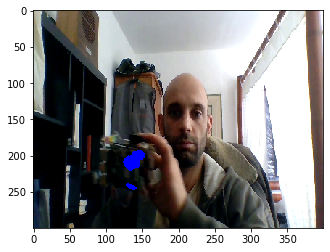

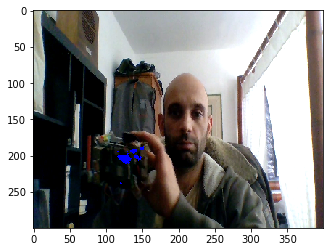

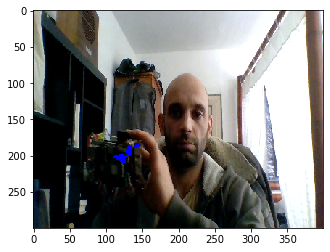

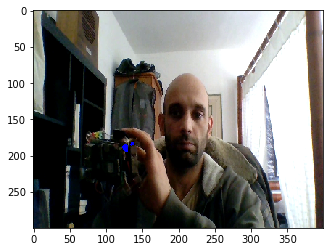

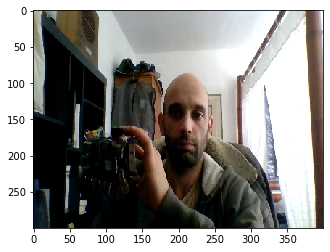

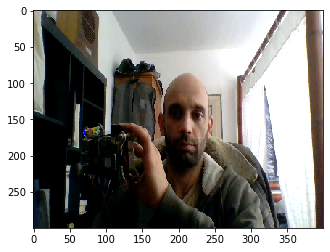

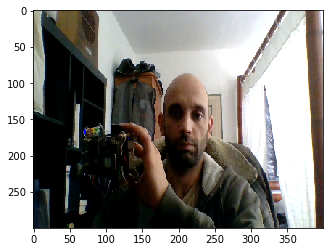

In [100]:
threshold = 0.9

for batch in valid_batches:
    for i in range(batch_size):
        img = batch[0][i,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        pred = model.predict(img.reshape((1, img_size[1], img_size[0], img_size[2])))
        for j in range(class_nb):
            msk = pred[i,:,:,j]
            img[msk>=threshold] = colors[j]
        plt.figure()
        plt.imshow(img)